<a href="https://colab.research.google.com/github/SESHG14/ESRGAN_TEACHER_2023/blob/main/ESRGAN_Teacher_3_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Super Resolution using ESRGAN model


---

This attempt will cover training on a dataset as well as implementation.

Dataset: reduced mirflickr dataset: 5000/25000 images

http://press.liacs.nl/mirflickr/mirdownload.html

Starting with image resizing for testing purposes. Here, we are resizing them to 128x128 that will be  used as HR images and
32x32 that will be used as LR images.

Once resized, the images can now be used to train the model.

Importing Relevant Classes:
- Tensorflow
- Keras
- OpenCV
- NumPy
- MatPlotLib

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

#Generator Structure:
After importing libraries, we define each of the of the Generator blocks

- Residual Block: Conv2D, Batch Normalization, PReLU || Conv2D, Batch Normalization

- Upscale Block: Conv2D, UpSampling2D,PReLU

In [ ]:
def res_block(ip):

    temp = ip

    # 1 - initial
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = LeakyReLU(alpha=0.2)(res_model)
    res_model = add([temp,res_model])

    # 2
    temp = res_model
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = LeakyReLU(alpha=0.2)(res_model)
    res_model = add([temp,res_model])
    # 3
    temp = res_model
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = LeakyReLU(alpha=0.2)(res_model)
    res_model = add([temp,res_model])
    # 4
    temp = res_model
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = LeakyReLU(alpha=0.2)(res_model)
    res_model = add([temp,res_model])
    # Final Convolution
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)

    #res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)

    return add([ip,res_model])

def res_in_res_block(ip):

    #1
    compound_res = res_block(ip)
    #2
    compound_res = res_block(compound_res)
    #3
    compound_res = res_block(compound_res)

    return add([ip,compound_res])


def upscale_block(ip):

    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    #up_model = PReLU(shared_axes=[1,2])(up_model)
    up_model = LeakyReLU(alpha=0.2)(up_model)

    return up_model

# Proposed ESRGAN Generator
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    #layers = PReLU(shared_axes=[1,2])(layers)
    layers = LeakyReLU(alpha=0.2)(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_in_res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    #layers = Conv2D(64, (3,3), padding="same")(layers)
    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)


#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):

    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)

    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)

    disc_model = LeakyReLU( alpha=0.2 )(disc_model)

    return disc_model

#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64

    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)

    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

#VGG19 for the feature map obtained by the j-th convolution (after activation)
#before the i-th maxpooling layer within the VGG19 network.(as described in the paper)
#Build a pre-trained VGG19 model that outputs image features extracted at the
# third block of the model
# VGG architecture: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
from keras.applications import VGG19

def build_vgg(hr_shape):

    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)

    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)

    gen_features = vgg(gen_img)

    disc_model.trainable = False
    validity = disc_model(gen_img)

    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

Load the LR Images:

In [ ]:
n=5000
lr_list = os.listdir("/content/drive/MyDrive/Image datasets/data/lr_images")[:n]
lr_list.sort

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("/content/drive/MyDrive/Image datasets/data/lr_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)


hr_list = os.listdir("/content/drive/MyDrive/Image datasets/data/hr_images")[:n]
hr_list.sort

hr_images = []
for img in hr_list:
    img_hr = cv2.imread("/content/drive/MyDrive/Image datasets/data/hr_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

Viewing Images for verification:

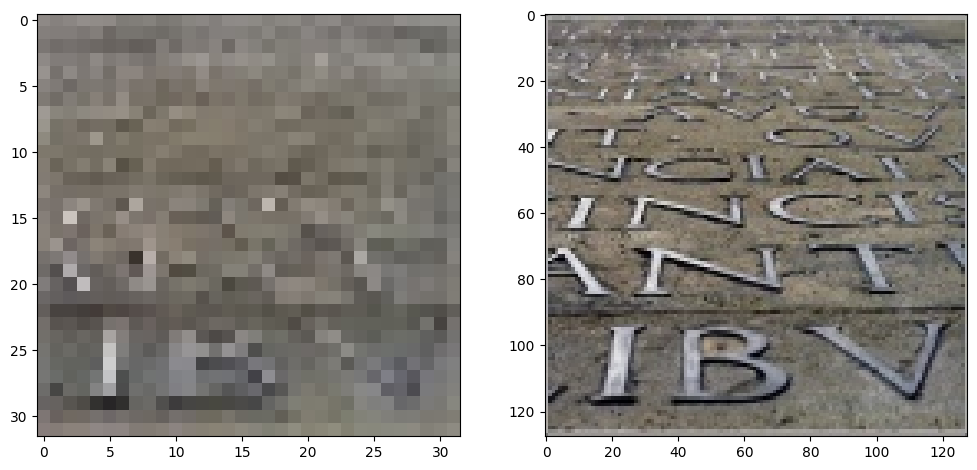

In [ ]:
# Plotting images fom teh dataset for verification
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()

Next Begin training on 5000 Images:

- 80% Training
- 20% Testing

Image values need to be presented as values between 0 and 1 ==> Divide image vector by 255. (MAX RGB pixel value is 255)

In [ ]:
#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

#Split into train and test sets
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images,
                                                      test_size=0.2, random_state=42)


<ipython-input-6-69a10137f657>:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


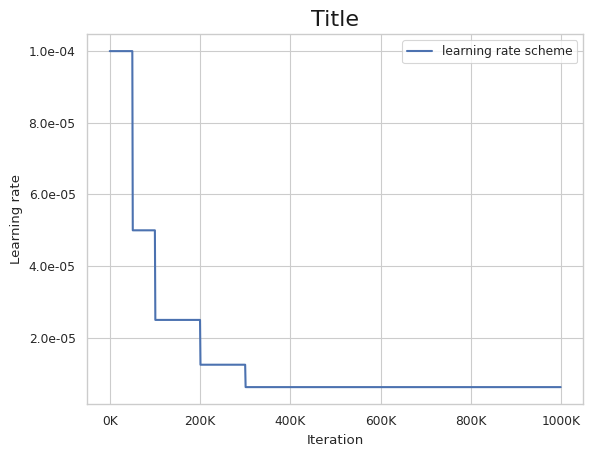

In [ ]:
import tensorflow as tf

def MultiStepLR(initial_learning_rate, lr_steps, lr_rate, name='MultiStepLR'):
    """Multi-steps learning rate scheduler."""
    lr_steps_value = [initial_learning_rate]
    for _ in range(len(lr_steps)):
        lr_steps_value.append(lr_steps_value[-1] * lr_rate)
    return tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=lr_steps, values=lr_steps_value)


def CosineAnnealingLR_Restart(initial_learning_rate, t_period, lr_min):
    """Cosine annealing learning rate scheduler with restart."""
    return tf.keras.experimental.CosineDecayRestarts(
        initial_learning_rate=initial_learning_rate,
        first_decay_steps=t_period, t_mul=1.0, m_mul=1.0,
        alpha=lr_min / initial_learning_rate)



    # pretrain PSNR lr scheduler
lr_scheduler_D = MultiStepLR(1e-4, [50000, 100000, 200000, 300000], 0.5)

    # ESRGAN lr scheduler
lr_scheduler_G = MultiStepLR(1e-4, [50000, 100000, 200000, 300000], 0.5)

    # Cosine Annealing lr scheduler
    # lr_scheduler = CosineAnnealingLR_Restart(2e-4, 250000, 1e-7)

    ##############################
    # Draw figure
    ##############################
N_iter = 1000000
step_list = list(range(0, N_iter, 1000))
lr_list = []
for i in step_list:
     current_lr = lr_scheduler_G(i).numpy()
     lr_list.append(current_lr)

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
mpl.style.use('default')
import seaborn
seaborn.set(style='whitegrid')
seaborn.set_context('paper')

plt.figure(1)
plt.subplot(111)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
plt.title('Title', fontsize=16, color='k')
plt.plot(step_list, lr_list, linewidth=1.5, label='learning rate scheme')
legend = plt.legend(loc='upper right', shadow=False)
ax = plt.gca()
labels = ax.get_xticks().tolist()
for k, v in enumerate(labels):
    labels[k] = str(int(v / 1000)) + 'K'
ax.set_xticklabels(labels)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))

ax.set_ylabel('Learning rate')
ax.set_xlabel('Iteration')
fig = plt.gcf()
plt.show()

# Initializing Optimizer Objects

In [ ]:
optimizer_G = tf.keras.optimizers.Adam(learning_rate=lr_scheduler_G,
                                       beta_1=0.9,
                                       beta_2=0.999)
optimizer_G.build

optimizer_D = tf.keras.optimizers.Adam(learning_rate=lr_scheduler_D,
                                       beta_1=0.9,
                                       beta_2=0.999)
optimizer_D.build


<bound method Adam.build of <keras.src.optimizers.adam.Adam object at 0x7d143b177e20>>

# Loss Functions

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input, VGG19


def PixelLoss(criterion='l1'):
    """pixel loss"""
    if criterion == 'l1':
        return tf.keras.losses.MeanAbsoluteError()
    elif criterion == 'l2':
        return tf.keras.losses.MeanSquaredError()
    else:
        raise NotImplementedError(
            'Loss type {} is not recognized.'.format(criterion))


def ContentLoss(criterion='l1', output_layer=54, before_act=True):
    """content loss"""
    if criterion == 'l1':
        loss_func = tf.keras.losses.MeanAbsoluteError()
    elif criterion == 'l2':
        loss_func = tf.keras.losses.MeanSquaredError()
    else:
        raise NotImplementedError(
            'Loss type {} is not recognized.'.format(criterion))
    vgg = VGG19(input_shape=(None, None, 3), include_top=False)

    if output_layer == 22:  # Low level feature
        pick_layer = 5
    elif output_layer == 54:  # Hight level feature
        pick_layer = 20
    else:
        raise NotImplementedError(
            'VGG output layer {} is not recognized.'.format(criterion))

    if before_act:
        vgg.layers[pick_layer].activation = None

    fea_extrator = tf.keras.Model(vgg.input, vgg.layers[pick_layer].output)

    @tf.function
    def content_loss(hr, sr):
        # the input scale range is [0, 1] (vgg is [0, 255]).
        # 12.75 is rescale factor for vgg featuremaps.
        preprocess_sr = preprocess_input(sr * 255.) / 12.75
        preprocess_hr = preprocess_input(hr * 255.) / 12.75
        sr_features = fea_extrator(preprocess_sr)
        hr_features = fea_extrator(preprocess_hr)

        return loss_func(hr_features, sr_features)

    return content_loss


def DiscriminatorLoss(gan_type='ragan'):
    """discriminator loss"""
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    sigma = tf.sigmoid

    def discriminator_loss_ragan(hr, sr):
        return 0.5 * (
            cross_entropy(tf.ones_like(hr), sigma(hr - tf.reduce_mean(sr))) +
            cross_entropy(tf.zeros_like(sr), sigma(sr - tf.reduce_mean(hr))))

    def discriminator_loss(hr, sr):
        real_loss = cross_entropy(tf.ones_like(hr), sigma(hr))
        fake_loss = cross_entropy(tf.zeros_like(sr), sigma(sr))
        return real_loss + fake_loss

    if gan_type == 'ragan':
        return discriminator_loss_ragan
    elif gan_type == 'gan':
        return discriminator_loss
    else:
        raise NotImplementedError(
            'Discriminator loss type {} is not recognized.'.format(gan_type))


def GeneratorLoss(gan_type='ragan'):
    """generator loss"""
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    sigma = tf.sigmoid

    def generator_loss_ragan(hr, sr):
        return 0.5 * (
            cross_entropy(tf.ones_like(sr), sigma(sr - tf.reduce_mean(hr))) +
            cross_entropy(tf.zeros_like(hr), sigma(hr - tf.reduce_mean(sr))))

    def generator_loss(hr, sr):
        return cross_entropy(tf.ones_like(sr), sigma(sr))

    if gan_type == 'ragan':
        return generator_loss_ragan
    elif gan_type == 'gan':
        return generator_loss
    else:
        raise NotImplementedError(
            'Generator loss type {} is not recognized.'.format(gan_type))

In [ ]:
    pixel_loss_fn = PixelLoss("l1")
    fea_loss_fn = ContentLoss("l1")
    gen_loss_fn = GeneratorLoss("ragan")
    dis_loss_fn = DiscriminatorLoss("ragan")

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:



hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
#generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer= optimizer_D, metrics=['accuracy'])
#discriminator.summary()

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           15616     ['input_1[0][0]']             
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)           0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 64)           36928     ['leaky_re_lu[0][0]']         
                                                                                              

In [ ]:
# Cimpilation Parameters:
# Loss: binary_crossentropy
# Content: feature map obtained by the j-th convolution (after activation)
# before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image.
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer=optimizer_G)
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 model (Functional)          (None, 128, 128, 3)          9727811   ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model_1 (Functional)        (None, 1)                    3824928   ['model[0][0]']               
                                                          1                                 

#Structure of Generator

In [ ]:
import keras.utils
img_file = './model_arch.png'

keras.utils.plot_model(generator, to_file=img_file, show_shapes=True, show_layer_names=True)

# Batch Size:

A batch size of 1 was used. Research related to SRGAN indicates that a batch size of 1 produces the best results.

In [ ]:

batch_size = 1
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

#Training The Model:

- Epochs: 25
- Model was saved after every 5 Epochs => 5 Models produced

In [ ]:
epochs = 25
for e in range(epochs):

    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.

    #gen and disc losses.
    g_losses = []
    d_losses = []


    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training

        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images

        #training the discriminator on fake and real HR images.
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)

        #training the generator by fixing discriminator as non-trainable
        discriminator.trainable = False

        #Average the discriminator loss
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real)

        #Extract VGG features
        image_features = vgg.predict(hr_imgs)

        #Train the generator via GAN.
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])

        #Save losses
        d_losses.append(d_loss)
        g_losses.append(g_loss)

    #Convert the list of losses to an array
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)

    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)

    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)
    generator.save("/content/drive/MyDrive/Image datasets/data/models/GEN6/gen6_e_"+ str(e+1) +".h5")

    if (e+1) % 5 == 0:
        #Save the generator after every 5 epochs
        generator.save("/content/drive/MyDrive/Image datasets/data/models/gen6_e_"+ str(e+1) +".h5")

#Testing the trained Model:

we can now implement the trained model to test. The model was trained for 15 epochs and saved every 5 epochs. The last saved model (15) will be used.

In [ ]:
from keras.models import load_model
from numpy.random import randint

generator = load_model('/content/drive/MyDrive/Image datasets/data/models/gen_e_15.h5', compile=False)


[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()


Test 2: 15 Epochs

In [ ]:
from keras.models import load_model
from numpy.random import randint

generator = load_model('/content/drive/MyDrive/Image datasets/data/models/gen2_e_5.h5', compile=False)


[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

Test 3: 10 Epochs

In [ ]:

generator2 = load_model('/content/drive/MyDrive/Image datasets/data/models/gen_e_10.h5', compile=False)


[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator2.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

Test 4: Loading ignored since model is already loaded.

In [ ]:
[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator2.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

Real World Test:


In [ ]:
from keras.models import load_model
from numpy.random import randint

generator = load_model('/content/drive/MyDrive/Image datasets/data/models/gen5_e_10.h5', compile=False)

input = cv2.imread("/content/drive/MyDrive/Real_Test.jpg")


input_hr = cv2.resize(input, (128,128))

input_lr = cv2.resize(input, (32,32))

input_lr = cv2.cvtColor(input_lr,cv2.COLOR_BGR2RGB)
input_hr = cv2.cvtColor(input_hr,cv2.COLOR_BGR2RGB)

input_lr = input_lr / 255.
input_hr = input_hr / 255.

input_lr = np.expand_dims(input_lr, axis=0)
input_hr = np.expand_dims(input_hr, axis=0)

generated_output = generator.predict(input_lr)

# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(input_lr[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_output[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(input_hr[0,:,:,:])

plt.show()

In [ ]:
from keras.models import load_model
from numpy.random import randint

generator = load_model('/content/drive/MyDrive/Image datasets/data/models/gen5_e_15.h5', compile=False)

input = cv2.imread("/content/drive/MyDrive/Real_Test.jpg")


input_hr = cv2.resize(input, (128,128))

input_lr = cv2.resize(input, (32,32))

input_lr = cv2.cvtColor(input_lr,cv2.COLOR_BGR2RGB)
input_hr = cv2.cvtColor(input_hr,cv2.COLOR_BGR2RGB)

input_lr = input_lr / 255.
input_hr = input_hr / 255.

input_lr = np.expand_dims(input_lr, axis=0)
input_hr = np.expand_dims(input_hr, axis=0)

generated_output = generator.predict(input_lr)

# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(input_lr[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_output[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(input_hr[0,:,:,:])

plt.show()

#Conversion to TFLite

In [ ]:
import tensorflow as tf

saved_model_dir = '/content/drive/MyDrive/Image datasets/data/models/gen_e_15.h5'

keras_model = tf.keras.models.load_model(saved_model_dir)

converter = tf.lite.TFLiteConverter.from_keras_model(keras_model) # path to the SavedModel directory
tflite_model = converter.convert()

In [ ]:
open("/content/drive/MyDrive/Image datasets/data/models/converted_model.tflite", "wb").write(tflite_model)

8175848

# Pretrained Model

In [ ]:

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import tensorflow_hub as hub
import tensorflow as tf

model = hub.load("https://tfhub.dev/captain-pool/esrgan-tf2/1")
##model.compile()
# To add an extra dimension for batch, use tf.expand_dims()
#low_resolution_image = load_image() # Low Resolution Image of shape [batch_size, height, width, 3]
#low_resolution_image = tf.cast(low_resolution_image, tf.float32)


input = cv2.imread("/content/drive/MyDrive/Real_Test.jpg")

#input = tf.cast(input, tf.float32)

input_hr = cv2.resize(input, (256,256))

input_lr = cv2.resize(input, (32,32))

input_lr = cv2.cvtColor(input_lr,cv2.COLOR_BGR2RGB)
input_hr = cv2.cvtColor(input_hr,cv2.COLOR_BGR2RGB)

input_lr = tf.cast(input_lr, tf.float32)
input_lr = input_lr / 255.

#input_hr = input_hr / 255.

input_lr = np.expand_dims(input_lr, axis=0)
input_hr = np.expand_dims(input_hr, axis=0)

super_resolution = model(input_lr) # Perform Super Resolution here

#tf.cast(tf.clip_by_value(super_resolution, 0, 255), tf.uint8)


# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(input_lr[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(super_resolution[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(input_hr[0,:,:,:])

plt.show()

